In [37]:
curr_dir = '/home/vayzenbe/GitHub_Repos/GiNN'

import sys
sys.path.insert(1, f'{curr_dir}/Models')
import os, argparse
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image, ImageOps,  ImageFilter
from itertools import chain
import pandas as pd
import numpy as np
import cornet
import model_funcs
import matplotlib.pyplot as plt
from statistics import mean
%matplotlib inline

In [38]:
stim_dir = f"{curr_dir}/Stim/"
weights_dir = f"/lab_data/behrmannlab/vlad/ginn/model_weights"

train_cond = ['general', 'face','imagenet_oneface',"mixed_imagenet_vggface"]
n_classes = [600, 600,601,1200]
#model_types = ['imagenet_objects']
#model_types = ['vggface']
model_epochs = [5, 10, 15, 20, 25, 30]

model_type = 'classify'

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

criterion = nn.MSELoss()
criterion = criterion.cuda()

In [39]:
def image_loader(image_name):
    im = Image.open(image_name).convert("RGB")
    #make image grayscale
    image_name = ImageOps.grayscale(im).convert("RGB")
    #image_name = image_name.filter(ImageFilter.GaussianBlur(radius=4))
    """load image, returns cuda tensor"""
    im = Variable(normalize(to_tensor(scaler(im))).unsqueeze(0))
    im = im.cuda()
    return im

In [40]:
def load_files(dirName):
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(dirName):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
            
    return listOfFiles    

In [41]:
def habituate_model(encoder, decoder, optimizer, im):
    early_hab = 0.0
    late_hab = []
    
    decoder.train()
    #start habituation/training loop
    for ep in range(0,max_epochs):
        train_loss = 0.0 

        n = 0

        optimizer.zero_grad() #zero out gradients from previous epoch

        encode_out = encoder(im)#Get encoder features
        
        decode_out = decoder(encode_out) #Run features through decoder

        loss = criterion(decode_out, im)#Calculate loss

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()


        train_loss += (loss.item()*im.size(0))
        n = n +1
        #print(train_loss, loss.item()*frames.size(0), n)

        if ep < hab_min:
            early_hab += train_loss #track loss for the first 4 trials
            #print(ep, train_loss)
        elif ep >= hab_min:
            hab_start = early_hab / hab_min #Determine habituation criterion
            late_hab.append(train_loss) #add current loss to habituation
            hab_end = mean(late_hab[(len(late_hab)-4):len(late_hab)]) #calcualte mean of last 4 hab trials

            #print(ep, train_loss, hab_start, hab_end)
            
            if hab_end < (hab_start/2) and ep >= int(hab_min *2) or ep == (max_epochs-1): #test if habituated
                
                return decoder, ep, hab_start, hab_end
                break

In [42]:
def test_model(encoder, decoder, im):
    #test model
    decoder.eval()
    test_loss = 0.0 
    with torch.no_grad():
        encode_out = encoder(im)#Get encoder features
        decode_out = decoder(encode_out) #Run features through decoder
        loss = criterion(decode_out, im) #Calculate loss

        test_loss += (loss.item()*im.size(0))
        
        return test_loss

In [43]:
def determine_ident_orient(file_name,cond_dir):

    file_name = file_name.replace(f'{stim_dir}/{cond_dir}/','')
    identity = file_name.replace('_left.jpg', '')
    identity = identity.replace('_right.jpg', '')
    identity = identity.replace('_front.jpg', '')

    orient = file_name.replace(f'{identity}_', '')
    orient = orient.replace('.jpg', '')
    
    return identity, orient


In [44]:
def determine_conds(hab_ident, test_ident, hab_orient, test_orient):
    if hab_ident == test_ident:
        ident_cond = "same"
    else:
        ident_cond = "diff"

    if hab_orient == test_orient:
        orient_cond = "same"
    else:
        orient_cond = "diff"

    return ident_cond, orient_cond

In [45]:
def calc_acc(df, orient):
    #Calc front acc
    acc =[]
    same = df['test_loss'][(df["identity"] == 'same') & (df["orient"] == orient)]
    diff = df['test_loss'][(df["identity"] == 'diff') & (df["orient"] == orient)]

    for ss in same:
        for dd in diff:
            acc.append(dd/(ss+dd))   
    
    return pd.Series(acc).mean(), pd.Series(acc).sem()


In [46]:
def plot_line(df_plot, df_conds):
    
    plt.figure()
    for dc in df_conds:    
        plt.errorbar(df_plot['epoch'], df_plot[dc],  yerr=df_plot[f'{dc}_se'], label=dc)
    
  
    plt.xlabel("Epochs")
    plt.ylabel("Activation/Preference")
    #ax.set_ylabel('Activation')
    #print(f'{df_plot["model][0]}-test')
    plt.title(f'{df_plot["model_type"][0]} model trained with {df_plot["train_type"][0]}')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{curr_dir}/Results/orientation/figures/{df_plot["model_type"][0]}_{df_plot["train_type"][0]}.png',bbox_inches='tight')
    

Viewpoint invariance experiment

In [24]:
hab_cond = 'cfmt_front'
test_cond = 'cfmt'

hab_min = 3
max_epochs = 24


In [34]:
'''
Habituation dishabituation loop
'''
hab_files = load_files(f'{stim_dir}/{hab_cond}')
test_files = load_files(f'{stim_dir}/{test_cond}')

for tcn, tc  in enumerate(train_cond):
    for ee in model_epochs:
        #load model 
        encoder = model_funcs.load_model(model_type, tc, ee, weights_dir, n_classes[tcn])
        encoder, decoder = model_funcs.make_ae_decoder(encoder)
        encoder.eval()

        optimizer = torch.optim.Adam(decoder.parameters(), lr=0.01)

        df = pd.DataFrame(columns = ['model_type', 'train_type', 'epoch',
                                     'hab_im', 'test_im', 'identity', 'orient',
                                     'hab_trials', 'hab_start', 'hab_end', 'test_loss']) 

        for hab_im in hab_files:

            hab_ident, hab_orient = determine_ident_orient(hab_im,hab_cond)

            im = image_loader(hab_im)
            #run habituation on current image and model; return trained decoder
            decoder, hab_trials, hab_start, hab_end  = habituate_model(encoder, decoder, optimizer, im)

            for test_im in test_files:
                #test_im= "/home/vayzenbe/GitHub_Repos/GiNN/Stim//cfmt/Jim_left.jpg"

                test_ident, test_orient = determine_ident_orient(test_im,test_cond)


                im = image_loader(test_im)
                test_loss = test_model(encoder,decoder, im)

                ident_cond, orient_cond = determine_conds(hab_ident, test_ident, hab_orient, test_orient)
                trial_results = [model_type, tc, ee, hab_im, test_im,ident_cond, orient_cond, hab_trials, hab_start, hab_end, test_loss]
                #print(trial_results)
                trial_results = pd.Series(trial_results, index = df.columns)
                df = df.append(trial_results, ignore_index=True)

        df.to_csv(f'{curr_dir}/Results/orientation/{model_type}_{tc}_{ee}_orientation.csv', sep =",", index = False)


KeyboardInterrupt: 

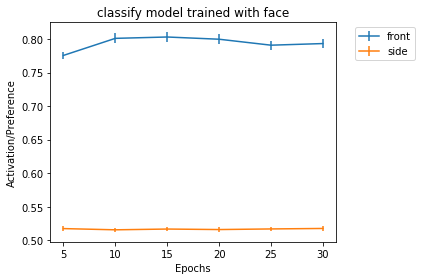

In [30]:
'''
Data plotting loop
'''
for tcn, tc  in enumerate(train_cond):
    summary_df = pd.DataFrame(columns = ['model_type', 'train_type', 'epoch',
                                     'front', 'side','front_se', 'side_se'])
    for ee in model_epochs:
        df = pd.read_csv(f'{curr_dir}/Results/orientation/{model_type}_{tc}_{ee}_orientation.csv')
        
        #append front accuracy and SE
        front_acc, front_se = calc_acc(df, 'same')
        side_acc, side_se = calc_acc(df, 'diff')
        
        temp_df = pd.Series([df['model_type'][0],df['train_type'][0], df['epoch'][0], 
                             front_acc, side_acc, front_se,side_se],
                            index = summary_df.columns) 
        summary_df = summary_df.append(temp_df, ignore_index = True)
    
    plot_line(summary_df, ['front', 'side'])
    
    
        
        

Other species experiment

In [58]:
hab_cond = 'facegen_front'
test_cond = 'facegen_front'

hab_min = 2
max_epochs = 4

In [59]:
'''
Habituation dishabituation loop
'''
hab_files = load_files(f'{stim_dir}/{hab_cond}')
test_files = load_files(f'{stim_dir}/{test_cond}')

for tcn, tc  in enumerate(train_cond):
    for ee in model_epochs:
        #load model 
        encoder = model_funcs.load_model(model_type, tc, ee, weights_dir, n_classes[tcn])
        encoder, decoder = model_funcs.make_ae_decoder(encoder)
        encoder.eval()

        optimizer = torch.optim.Adam(decoder.parameters(), lr=0.01)

        df = pd.DataFrame(columns = ['model_type', 'train_type', 'epoch',
                                     'hab_im', 'test_im', 'identity',
                                     'hab_trials', 'hab_start', 'hab_end', 'test_loss']) 

        for hab_im in hab_files:

            #hab_ident, hab_orient = determine_ident_orient(hab_im,hab_cond)

            im = image_loader(hab_im)
            #run habituation on current image and model; return trained decoder
            decoder, hab_trials, hab_start, hab_end  = habituate_model(encoder, decoder, optimizer, im)

            for test_im in test_files:
                #test_im= "/home/vayzenbe/GitHub_Repos/GiNN/Stim//cfmt/Jim_left.jpg"

                #test_ident, test_orient = determine_ident_orient(test_im,test_cond)


                im = image_loader(test_im)
                test_loss = test_model(encoder,decoder, im)

                if hab_im == test_im:
                    ident_cond = 'same'
                else:
                    ident_cond = 'diff'
                
                trial_results = [model_type, tc, ee, hab_im, test_im,ident_cond, hab_trials, hab_start, hab_end, test_loss]
                #print(trial_results)
                trial_results = pd.Series(trial_results, index = df.columns)
                df = df.append(trial_results, ignore_index=True)

        df.to_csv(f'{curr_dir}/Results/other_species/{model_type}_{tc}_{ee}_{hab_cond}.csv', sep =",", index = False)


In [60]:
def calc_species_acc(df):
    #Calc front acc
    acc =[]
    same = df['test_loss'][(df["identity"] == 'same')]
    diff = df['test_loss'][(df["identity"] == 'diff')]

    for ss in same:
        for dd in diff:
            acc.append(dd/(ss+dd))   
    
    return pd.Series(acc).mean(), pd.Series(acc).sem()


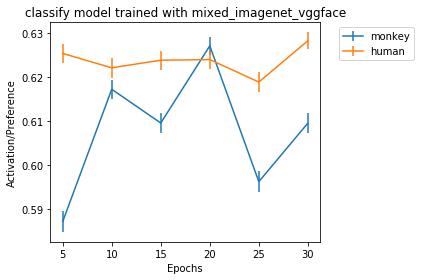

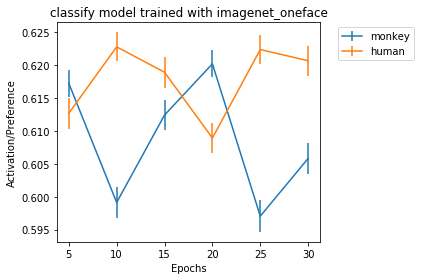

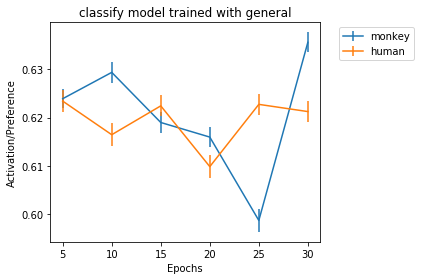

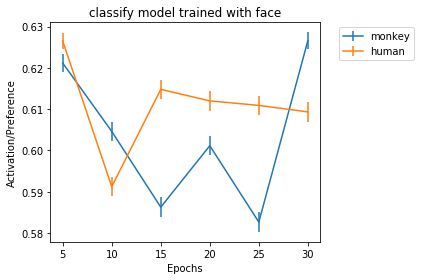

In [70]:
'''
Data plotting loop
'''
for tcn, tc  in enumerate(train_cond):
    summary_df = pd.DataFrame(columns = ['model_type', 'train_type', 'epoch',
                                     'monkey', 'monkey_se', "human", "human_se"])
    for ee in model_epochs:
        df_monkey = pd.read_csv(f'{curr_dir}/Results/other_species/{model_type}_{tc}_{ee}_monkey_front.csv')
        df_human = pd.read_csv(f'{curr_dir}/Results/other_species/{model_type}_{tc}_{ee}_facegen_front.csv')
        
        #append front accuracy and SE
        monkey_acc, monkey_se = calc_species_acc(df_monkey)
        human_acc, human_se = calc_species_acc(df_human)
        
        
        temp_df = pd.Series([df_monkey['model_type'][0],df_monkey['train_type'][0], df_monkey['epoch'][0], 
                             monkey_acc, monkey_se, human_acc, human_se],
                            index = summary_df.columns) 
        summary_df = summary_df.append(temp_df, ignore_index = True)
    
    plot_line(summary_df, ['monkey', 'human'])

In [69]:
df_monkey

,model_type,train_type,epoch,hab_im,test_im,identity,hab_trials,hab_start,hab_end,test_loss
0,classify,face,30,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,same,3,2.371237,0.220308,0.192634
1,classify,face,30,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,diff,3,2.371237,0.220308,0.426395
2,classify,face,30,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,diff,3,2.371237,0.220308,0.489445
3,classify,face,30,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,diff,3,2.371237,0.220308,0.702145
4,classify,face,30,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,diff,3,2.371237,0.220308,0.654218
...,...,...,...,...,...,...,...,...,...,...
284,classify,face,30,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,diff,3,0.479095,0.341816,0.498552
285,classify,face,30,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,diff,3,0.479095,0.341816,0.333456
286,classify,face,30,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,diff,3,0.479095,0.341816,0.378469
287,classify,face,30,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,/home/vayzenbe/GitHub_Repos/GiNN/Stim//monkey_...,diff,3,0.479095,0.341816,0.117558


In [16]:
test3 = torch.reshape(test2, (1,1024,1,1))

In [17]:
test3.shape

torch.Size([1, 1024, 1, 1])